# import and functions

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Fs = 30000.0

def parts(list_, indices):
    indices = [0]+indices+[len(list_)]
    return [list_[v:indices[k+1]] for k, v in enumerate(indices[:-1])]

def RemoveSlowSequences(split,split2):
    timefiltered_split = []
    for i,item in enumerate(split2):
        if item[0] == 1:
            timefiltered_split = timefiltered_split + [split[i]]

    return(timefiltered_split)

def aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies):
    
    newseqs = []
    newlatencies = []
    # align to first poke:
    for index_1,fragments in enumerate(timesplitseqs):
        current_newseqs = []
        current_newlatencies = []
        count = -1
        seqs = False
        for index_2,sequence in enumerate(fragments):
            for index_3,transit in enumerate(sequence):
                if not str(transit)[0] == str(transit)[1]: # remove repeat pokes
                    if str(transit)[0] == '2':
                        seqs = True
                        current_newseqs = current_newseqs + [[]]
                        current_newlatencies = current_newlatencies + [[]]
                        count = count + 1
                        current_newseqs[count] = current_newseqs[count] + [transit]
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
                    elif seqs == True:
                        current_newseqs[count] = current_newseqs[count] + [transit]   
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
            seqs = False
 
        newseqs = newseqs + [current_newseqs]
        newlatencies = newlatencies + [current_newlatencies]
    return(newseqs,newlatencies)

def generate_processed_transitiontimesdataframe(processed_seqs,processed_latencies,counter):

    count = counter
    transits= []
    trial_number= []
    for fragment in processed_seqs:
        count = count + 1
        if len(fragment) > 0:
            for sequence in fragment:
                for transit in sequence:
                    trial_number = trial_number + [count]
                    transits = transits + [transit]
        else: ### deals with cases where there are no good transitions in a trial 
            transits = transits + ['nan']
            trial_number = trial_number + [count]

    times = []
    for fragment in processed_latencies:
        if len(fragment) > 0:
            for sequence in fragment:
                for time in sequence:
                    times = times + [time]
        else:
            times = times + ['nan']

    Processesed_Transition_Latencies = pd.DataFrame({'Trial': trial_number, 'Transitions' : transits,'Latencies' : times})

    return(Processesed_Transition_Latencies,count)

def sequence_contains_sequence(haystack_seq, needle_seq):
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            return True
    return False

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()

# set paths

In [24]:
### Paths


animal = 'seq006_implant1'

path = r'Z:\projects\sequence_squad\revision_data\organised_data\animals\\' + animal + '\\'

# Set as True to create baseline files that will need to be edited manually later to select timeframe:
create_intervales_txt = True



# main data loop 

This loops across the data structure for the given animal and uses the behavuour synchronisation file which relates preprocessed bpod data (poke times) to ephys timestamps. The output is a performance score (how well the mouse did the sequence across trials) in ephys time coordinates. This allows us to later chose an ephys time period when the animal was perfroming the task well/consitently. 

recording10_27-11-2024
recording11_28-11-2024
recording1_15-11-2024
recording2_16-11-2024
no data for this recording
recording3_18-11-2024
recording4_19-11-2024
recording5_20-11-2024
recording6_21-11-2024
recording7_22-11-2024
recording8_25-11-2024
recording9_26-11-2024


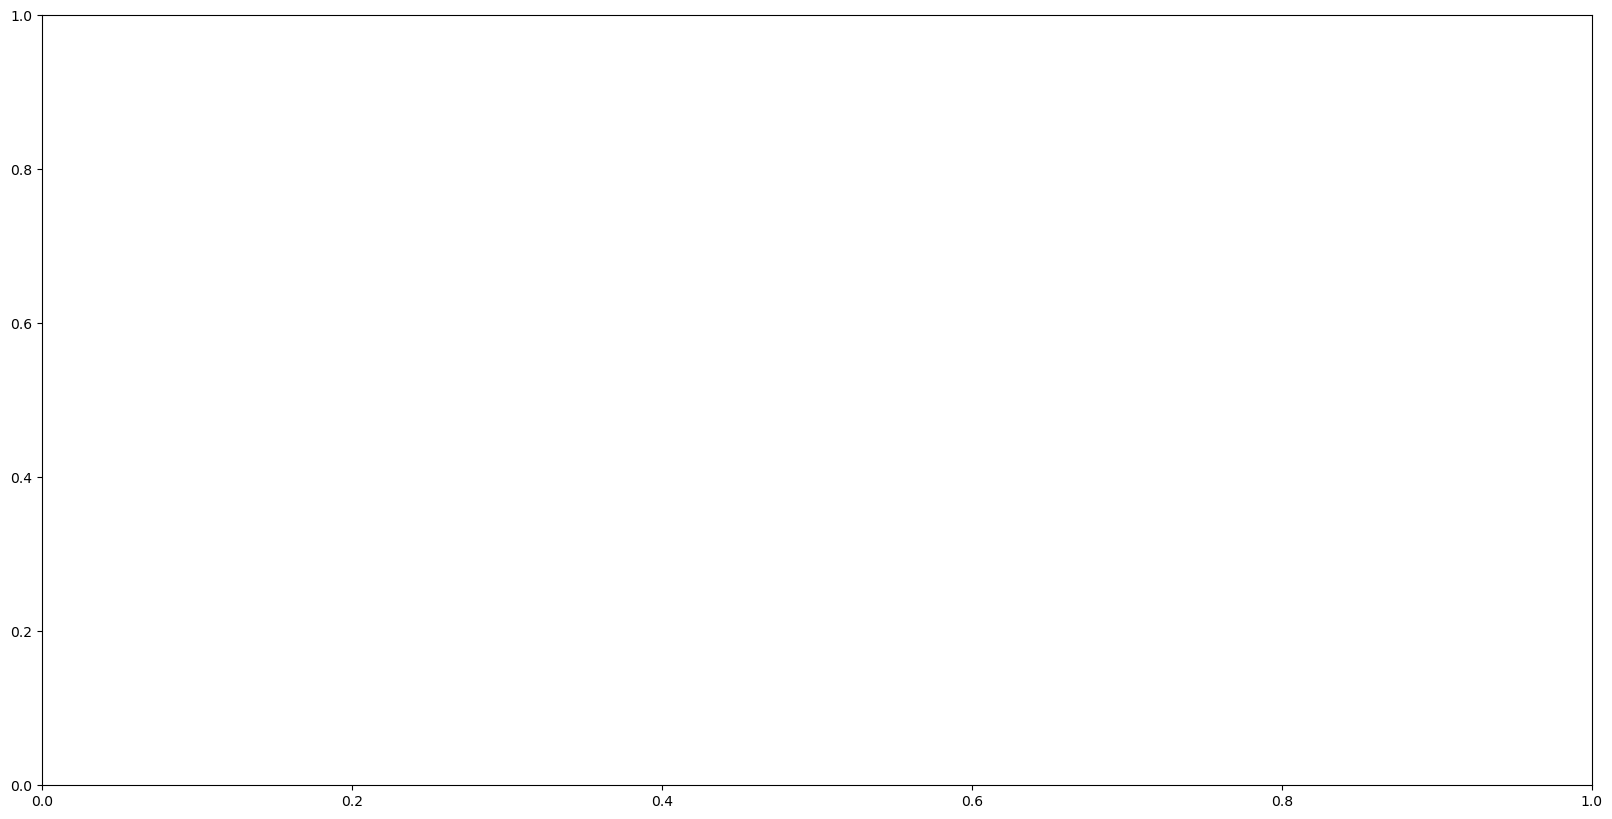

In [25]:
for recording in os.listdir(path):
    if not 'Store' in recording: # ignore ds store thing
        if 'recording' in recording:
            print(recording)
            current_path = os.path.join(path,recording,'behav_sync') + '\\'
            for file in os.listdir(current_path):
                if 'task' in file:
                    current_path =  os.path.join(current_path,file) + '\\' 
            try:         
                sync_data =  pd.read_csv(current_path + 'Transition_data_sync.csv')
                sync_data2 =  pd.read_csv(current_path + 'Behav_Ephys_Camera_Sync.csv')

                output_path = os.path.join(path,recording,'post_process_ppseq') + '\\' 

                # these are important for concainating trials later on!
                counter1 = -1
                counter2 = -1

                #split data by trials 
                trial_split_data = dict(tuple(sync_data.groupby('Trial_id')))

                # pull out transitions and timefilter data for each trial:
                transitions = []
                Tfilters= [[],[]]
                latencies = [[],[]]
                for i in trial_split_data:
                    transitions = transitions + [list(trial_split_data[i].loc[:,'Transition_type'])]
                    Tfilters[0] = Tfilters[0] + [list(trial_split_data[i].loc[:,'2s_Time_Filter_out_in'])]
                    latencies[0] = latencies[0] +[list(trial_split_data[i].loc[:,'out_in_Latency'])]   
                    # in in
                    Tfilters[1] = Tfilters[1] + [list(trial_split_data[i].loc[:,'2s_Time_Filter_in_in'])]
                    latencies[1] = latencies[1] +[list(trial_split_data[i].loc[:,'in_in_Latency'])]    

                # for each trial,remove transntions that were too long and split into reaminign time relevant fragments - but for both latency types, hence the loop
                timesplitseqs = [[],[]]
                for i in range(2):
                    Tfilt = Tfilters[i] # use out to in pokes first then in in .
                    for trial_index,time_filter in enumerate(Tfilt):
                        start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
                        split = parts(transitions[trial_index],list(np.array(start_end_inds)+1))
                        split2 = parts(Tfilt[trial_index],list(np.array(start_end_inds)+1))
                        TfiltSplit = RemoveSlowSequences(split,split2)
                        del split[::2] # remove every 2nd item eg. all the transitions that were timefilter = 0 so were too long. 
                        timesplitseqs[i] = timesplitseqs[i] + [TfiltSplit]

                ## do the exact same for latency - but for both latency types, hence the loop:
                timesplitlatencies = [[],[]]
                for i in range(2):
                    Tfilt = Tfilters[i] 
                    latency = latencies[i]
                    for trial_index,time_filter in enumerate(Tfilt):
                        start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
                        split = parts(latency[trial_index],list(np.array(start_end_inds)+1))
                        split2 = parts(Tfilt[trial_index],list(np.array(start_end_inds)+1))
                        TfiltSplit = RemoveSlowSequences(split,split2)
                        del split[::2] # remove every 2nd item eg. all the latencies that were timefilter = 0 so were too long. 
                        timesplitlatencies[i] = timesplitlatencies[i] + [TfiltSplit]

                # for fragments in each trial,sort and trim so that seqs start at initiation port poke and then remove fragments that are too short. ie. remove any transitions sequences that dont inlcude the first port or are just a single transition.
                processed_seqs,processed_latencies = aligntofirstpokeandremovesingletransits(timesplitseqs[0],timesplitlatencies[0])  ## use  timesplitlatencies[0] for Out to in Transition times 

                ## generate processed transition times dataframe:
                Processesed_Transition_Latencies_df,counter1 = generate_processed_transitiontimesdataframe(processed_seqs,processed_latencies,counter1)

                ## determine perfect sequences and correspondng training level and shaping parameters
                trial_perfects = []
                T_CorrectScores = [[],[],[],[]]
                T_RepeatScores = [[],[],[],[]]

                for trial_index,fragments in enumerate(processed_seqs):
                    perfect = []
                    for fragment in fragments:
                        if sequence_contains_sequence(fragment,[21, 16, 63, 37]):
                            perfect = perfect + [1]
                        else:
                            perfect = perfect + [0]

                    trial_perfects = trial_perfects + [perfect]  

                # calculate mean for each trial:
                perfectscore_trials = []
                for trial in trial_perfects:
                    if len(trial) == 0:
                        perfectscore_trials = perfectscore_trials + [0]
                    else:
                        perfectscore_trials = perfectscore_trials + [np.mean(trial)]

                first_p_ephys_time = sync_data2.FirstPoke_EphysTime.values
                first_p_ephys_time = first_p_ephys_time[~np.isnan(first_p_ephys_time)]

                fig, ax = plt.subplots(1, 1,figsize=(20,10))
                ax.plot(first_p_ephys_time,convolve_movmean(perfectscore_trials,20))
                ax.set_xlabel('trials',fontsize = 15)
                ax.set_ylabel('performance score',fontsize = 15)
                SaveFig('Performance score.png',output_path)

                out_df = pd.DataFrame({'ephys_time' : first_p_ephys_time ,
                                'Convolved_perfromance_score' : convolve_movmean(perfectscore_trials,20)})

                out_df.to_csv(output_path + '/Performance_score.csv')
                
                if create_intervales_txt:
                    if not 'Time_intervales.txt' in os.listdir(output_path):
                        ## create a txt file with example intervals for the perfect sequences:
                        text = 'Pre_sleep,[[0,100]]\nPost_sleep,[[200,300]]\nAwake,[[100,200]]'
                        with open(output_path + 'Time_intervales.txt', 'w') as f:
                            f.write(text)
                
            except:
                print('no data for this recording')